<center>
In God We Trust
</center>

# CE417: Artificial Intelligence

Dr. Mahdiyeh Soleymani Baghshah

Computer Engineering Department,
Sharif University of Technology,
Tehran, Tehran, Iran


## Markov Decision Process (30 Points)

HW3 :: Practical Question 2

<br>

Corresponding TA: Aryan Ahadinia, Saeed Hedayatiyan


In this question, We're going to implement a generic MDP solver, so we can solve every question by passing transition and reward functions. We use an example to test our implementation but it's important to write MDP solver functions in a generic form. So it's important to maintain notebook structure and only write codes and comment in annotated areas.

### Modeling a Problem (5 Points)

In a TV quiz show, there are several levels. At each level, if the participant answers the question correctly, they will receive some prize. If the participant's answer is wrong, they leave the competition empty-handed. Before each stage begins, the participant can decide whether to continue or withdraw and leave the game with the reward which they already earned.

Beside states representing each level, There are three terminal states of Win, Lost and Quit in the game. Actions in each state are quit and play. The player will go to the quit state with probability of 1 if they decide to take action quit. otherwise they will pass the level i by probability of win_ratio[i] and go to the state which represents the next level.

So the play / quit decision problem can be modeled as an MDP as below.

<p align="center">
<image src="./assets/quiz_problem.png">
</p>

Considering $100, $200, $300, $400 and $500 as rewards and 0.9, 0.7, 0.6, 0.3, 0.1 as win ratio for levels 0 to 4 respectively.

Complete two cells below to model the problem as an MDP. Write levels and actions as an str.


In [16]:
quiz_levels = [
    '0', '1', '2', '3', '4'
]
quiz_terminals = [
    "Win", "Lost", "Quit"
]

quiz_states = quiz_levels + quiz_terminals
quiz_actions = [
    "next_level", "quit"
]


In [17]:
from typing import Callable
from typing import List
from typing import Tuple
from typing import Union


In [49]:
from typing import Optional

# only considered transitions like: non-terminal->(non_terminal or terminal)
# the rest of them will not be iterated over.
def quiz_transition(state: str, action: str, next_state: str) -> Optional[float]:
    probs = [0.9, 0.7, 0.6, 0.3, 0.1]
    if state in quiz_terminals:
        return None
    if action == "next_level":
        if next_state == "Lost": # Lost State
            return 1.0 - probs[int(state)]
        else: # Quiz Levels and Win states
            return probs[int(state)]
    elif action == "quit":
        return 1.0

# rewards are only considered for transitions like: non-terminal->(non_terminal or terminal)
# in fac, the reward is attained when the transition is taken, and we are in next_state
# so, as terminals have no 'next_state', they have no reward.
def quiz_reward(state: str, action: str, next_state: str) -> Optional[Union[float, int]]:
    rewards = [100, 200, 300, 400, 500]
    if state in quiz_terminals:
        return None
    if action == "quit":
        if next_state == "Quit":
            return sum(rewards[:quiz_states.index(state)])
        else:
            return None
    else: # next_level
        if next_state == "Lost":
            return -sum(rewards[:quiz_states.index(state)])
        elif quiz_states.index(next_state) - quiz_states.index(state) == 1:
            return 0
        else:
            return None


### Value Iteration (10 Points)

Now we want to implement a function which does the value iteration process. Consider that this function must be a generic function to all MDP problems. So any internal reference to global variables is forbidden.

This function gets transition function, reward function, discounting factor (gamma), list of states, list of terminal states, list of all possible actions and current value of each state as input and must return two lists: (1) updated values of each state and (2) list of best action which can be taken in each state regarding current values.


In [50]:
def mdp_iterate(
    transition_function: Callable[[str, str, str], float],
    reward_function: Callable[[str, str, str], float],
    gamma: float,
    states: List[str],
    terminals: List[str],
    actions: List[str],
    current_values: List[Union[float, int]],
) -> Tuple[List[Union[float, int]]]:
    new_values = []
    best_actions = []
    non_terminals = [state for state in states if state not in terminals]
    for state in non_terminals:
        best_action = None
        best_action_expected_value = -float("inf")
        for action in actions:
            action_expected_value = 0
            for next_state in states:
                if state != next_state:
                    prob = transition_function(state, action, next_state)
                    reward = reward_function(state, action, next_state)
                    if prob is None or reward is None: # invalid transition
                        continue
                    action_expected_value += prob * (reward + gamma * current_values[states.index(next_state)])
            if action_expected_value > best_action_expected_value:
                best_action = action
                best_action_expected_value = action_expected_value   
        new_values.append(best_action_expected_value)
        best_actions.append(best_action)
    for state in terminals:
        new_values.append(0)
        best_actions.append(None)   
        
    return new_values, best_actions



### MDP Solving (5 Points)

Now write a function to use the iterative approach to calculate values of each state and solve the MDP problem.

This function gets transition function, reward function, discounting factor (gamma), list of states, list of terminal states, list of all possible actions and number of iterations as input and must return a dictionary which maps states to best action can be taken. For example:

```Python
{
    'S1': 'A1',
    'S2': 'A2',
    ...
}
```


In [51]:
from typing import Dict


def mdp_solve(
    transition_function: Callable[[str, str, str], float],
    reward_function: Callable[[str, str, str], float],
    gamma: float,
    states: List[str],
    terminals: List[str],
    actions: List[str],
    iter: int,
) -> Dict['str', 'str']:
    current_values = [0] * len(states)
    best_actions = []
    for _ in range(iter):
        current_values, best_actions = mdp_iterate(transition_function, reward_function, gamma, states, terminals, actions, current_values)
    return {states[i]: best_actions[i] for i in range(len(states))}  # Change this line to return the correct value


By now, running this code must solve the problem described above.


In [52]:
res = mdp_solve(
    quiz_transition,
    quiz_reward,
    1,
    quiz_states,
    quiz_terminals,
    quiz_actions,
    1000,
)

print(res)


{'0': 'next_level', '1': 'next_level', '2': 'quit', '3': 'quit', '4': 'quit', 'Win': None, 'Lost': None, 'Quit': None}


### Analyzing effect of discounting factor (10 Points)

Now, solve the problem for different values of discounting factor. Then draw a plot to show how increasing discounting factor effect on best decision that should be take. Then write a paragraph about the result.

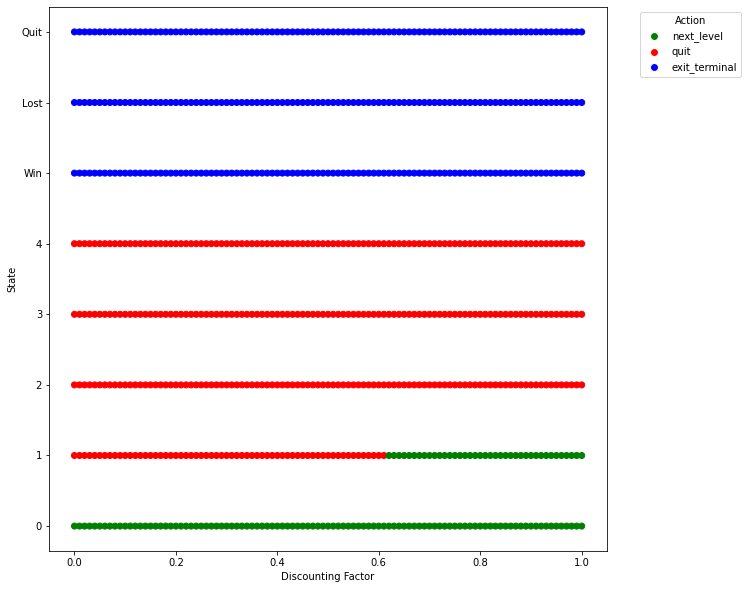

In [54]:
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.lines import Line2D
import numpy as np

data = []
for gamma in np.arange(0, 1.01, 0.01):
    res = mdp_solve(
        quiz_transition,
        quiz_reward,
        gamma,
        quiz_states,
        quiz_terminals,
        quiz_actions,
        1000,
    )
    for state in res:
        action = res[state]
        if action is None:
            action = "exit_terminal"
        data.append([state, action, gamma])

df = pd.DataFrame(data, columns=["state", "action", "gamma"])

fig, ax = plt.subplots(figsize=(10, 10))
colors = {"next_level": "green", "quit": "red", "exit_terminal": "blue"}

ax.scatter(df["gamma"], df["state"], c=df["action"].apply(lambda x: colors[x]))
plt.xlabel("Discounting Factor")
plt.ylabel("State")
# legend
handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor=v, label=k, markersize=8) for k, v in colors.items()]
ax.legend(title='Action', handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left')


######### Write Here (5 Points) ###########

As we increase 'Discounting Factor', the player will stay in the game for longer, and will try to win more money.
'Discounting Factor' affects the future rewards exponentially, thus, if its value is low, it will make future huge rewards less noticeable, and because of the recursive nature of 'Discounting Factor's effect, the further the final reward, the less valuable it will be. 
<br/>
For instance, as we have increased 'Gamma' from 0 to 1, the action of state '1' has changed. In this state and before 'Gamma' being 0.6, the player did not have the courage to progress in the levels and prefers to 'quit', but as 'Gamma' passes 0.6, the player becomes braver and optimistically decides to continue in the levels of the game.

